# Recent Surveys

This notebook evaluates the most recent surveys and is a benchmark to see how good we can predict consumption using the public available data.

In [13]:
cd ..

/home/sallinen/Programmation/predicting-poverty-through-time


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from lib import estimator_util as eu
from sklearn.linear_model import Ridge

from xgboost import XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
from lib import clusters_utils as cl


In [4]:
sns.set_theme()

In [5]:
complete_df, all_cols = eu.get_data("../data/lsms/processed/_all_real.csv", "../data/cnn_features/resnet_trans_all_countries_hyper.csv", "../data/")
countries = ["NG", "ETH" ,"TZA", "MW"]

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=1)
_ = pca.fit(complete_df[all_cols])
features_weights = list(zip(all_cols, pca.components_.T))

## Get names of useless OSM features for the 4 countries

In [7]:
X, _, _, _ = eu.get_recent_osm_features(complete_df, countries, all_cols)
X = pd.DataFrame(X, columns=all_cols)
null_features = X.loc[:, (X == 0).any(axis=0)].keys()

## Predict r^2 for every country in our dataset.

In [8]:
def cnn_osm(complete, model_, country, **params):
    tmp_df = complete.loc[complete.country == country]
    years = tmp_df.groupby(["year"]).groups.keys()
    year = max(years)
    recent_df_complete = tmp_df.loc[tmp_df.year == year]
    split_map = cl.split_k_sets(10, lat=recent_df_complete["lat"], lon=recent_df_complete["lon"])
    X, y = eu.get_recent_features(tmp_df, [country], all_cols, null_osm_features=null_features)
    r2, y_real, y_predicted, trained_model = eu.run_model(X, y, model_, seed=1, kf= cl.folds_from_split(split_map), **params)
    fig = eu.plot_predictions(y_real, y_predicted, r2, country, year)
    fig.savefig(f"../figs/{country}_{year}_cnnosm_{model_.__name__}.pdf", dpi=600)
    return trained_model

In [9]:
from sklearn.model_selection import GridSearchCV

def optimize_params(complete, model_, params, seed, doPlot=False, k=10):

    countries = ["NG", "ETH", "TZA", "MW"]
    best_params = {"NG":{}, "ETH": {}, "TZA": {}, "MW": {}}
    fig, axs = plt.subplots(len(params.keys()), 1, squeeze=False)
    for ax in axs.flat:
        ax.set(ylabel='r2')
    for country in tqdm(countries):
        tmp_df = complete.loc[complete.country == country]
        years = tmp_df.groupby(["year"]).groups.keys()
        year = max(years)
        recent_df_complete = tmp_df.loc[tmp_df.year == year]
        split_map = cl.split_k_sets(k, lat=recent_df_complete["lat"], lon=recent_df_complete["lon"])
        X, y = eu.get_recent_features(tmp_df, [country], all_cols)
        search = GridSearchCV(model_,param_grid=params, scoring='r2', cv=cl.folds_from_split(split_map))
        result = search.fit(X, y)
        for j, key in enumerate(params):
            if doPlot:
                fd = pd.DataFrame.from_dict(result.cv_results_)
                gd = fd.groupby(["param_"+key]).mean()
                axs[j,0].plot(params[key], gd["mean_test_score"], label=country + " - " + key)
                axs[j,0].set(xlabel=key)
                axs[j,0].legend()
            best_params[country].update({key : result.best_params_[key]})

    return best_params

# Predictions with Ridge Regression

100%|██████████| 4/4 [00:24<00:00,  6.08s/it]


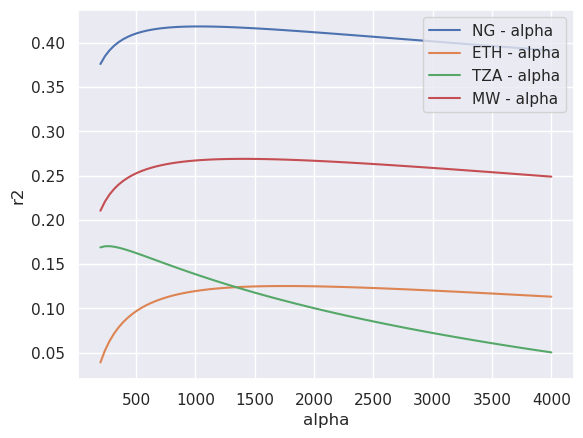

In [10]:
best_params = optimize_params(complete_df, Ridge(), params={'alpha': np.linspace(200, 4000,num=100)}, seed=1, doPlot = True)

In [11]:
for country in countries:
    print(best_params[country]['alpha'])

1044.4444444444443
1773.7373737373737
276.7676767676768
1389.8989898989898


100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


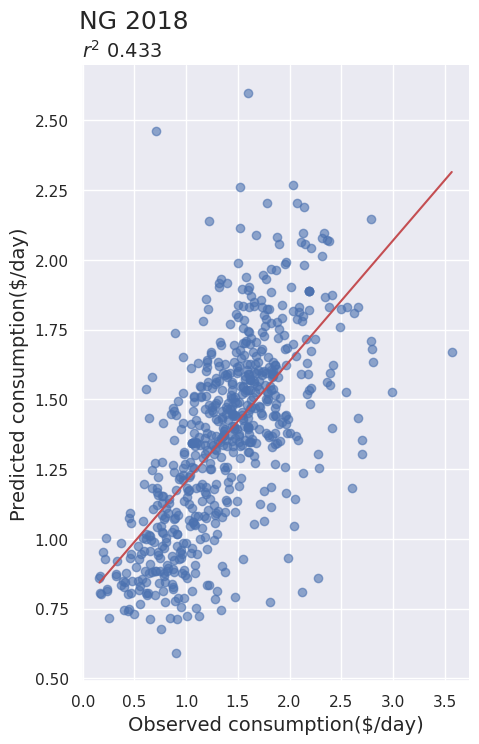

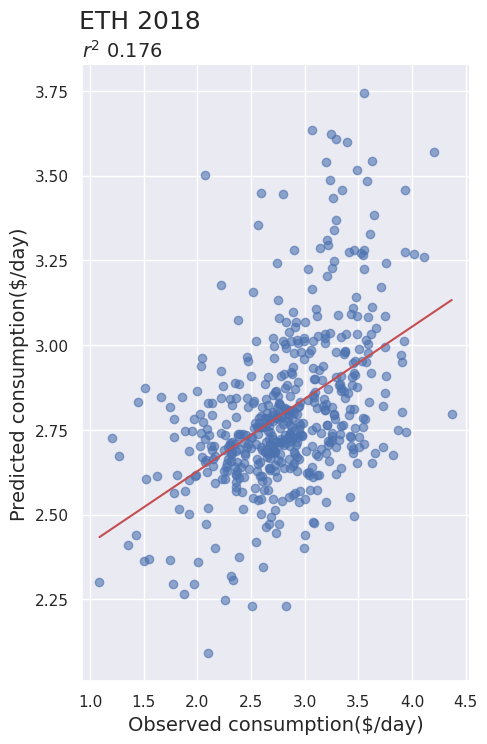

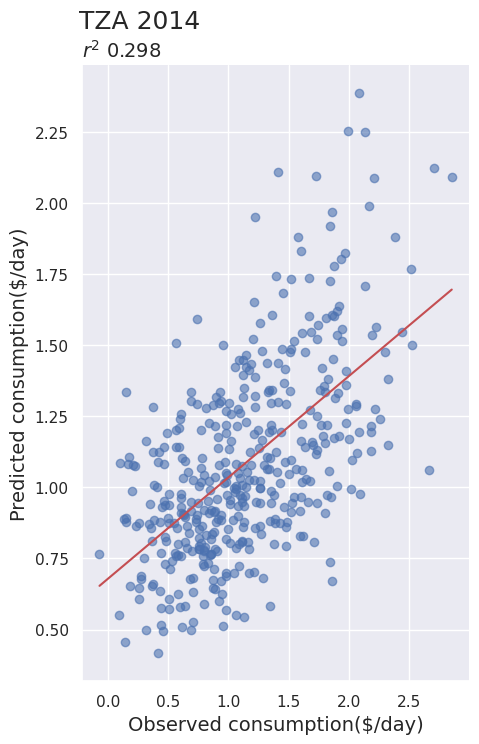

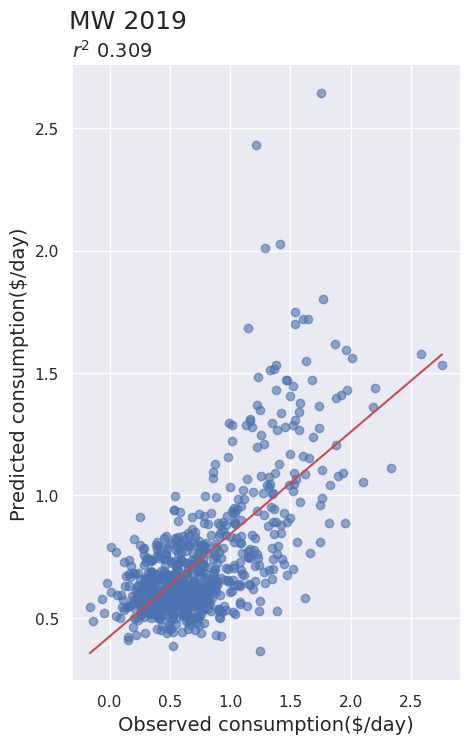

In [12]:
for country in tqdm(countries):
    cnn_osm(complete_df, Ridge, country, alpha = best_params[country]['alpha'])

# Predictions with XGBoost

100%|██████████| 4/4 [10:50<00:00, 162.54s/it]


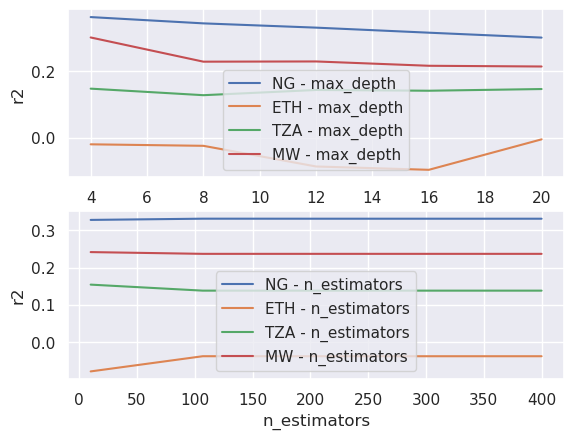

In [19]:
max_depth = np.linspace(4,20, num = 5, dtype=int)
n_estimators = np.linspace(10,400, num = 5, dtype=int)
best_params = optimize_params(complete_df, XGBRegressor(tree_method="gpu_hist", gpu_id=0, random_state=1), params={'max_depth': max_depth, 'n_estimators': n_estimators}, seed=1, doPlot = True, k=10)

In [20]:
print(best_params)

{'NG': {'max_depth': 4, 'n_estimators': 10}, 'ETH': {'max_depth': 20, 'n_estimators': 107}, 'TZA': {'max_depth': 4, 'n_estimators': 10}, 'MW': {'max_depth': 4, 'n_estimators': 10}}


4it [00:19,  4.87s/it]


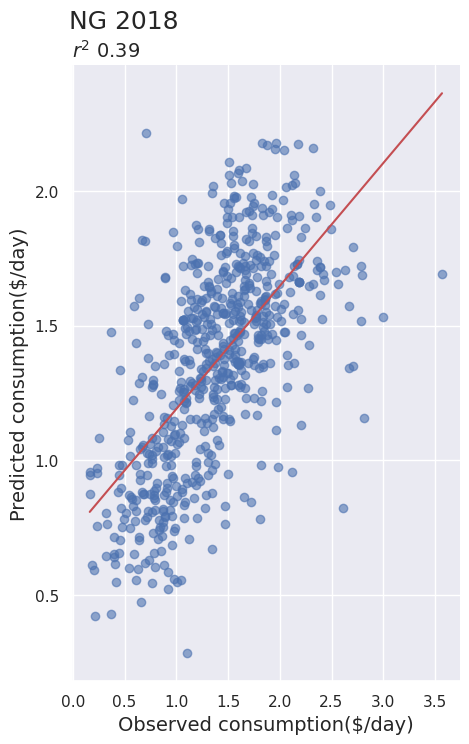

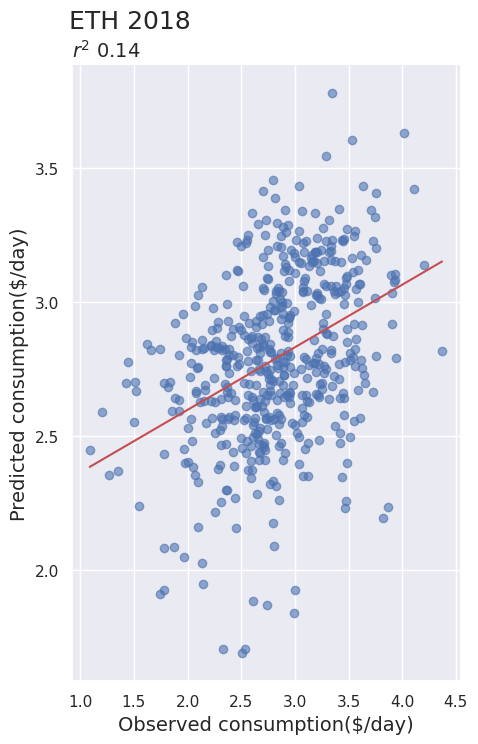

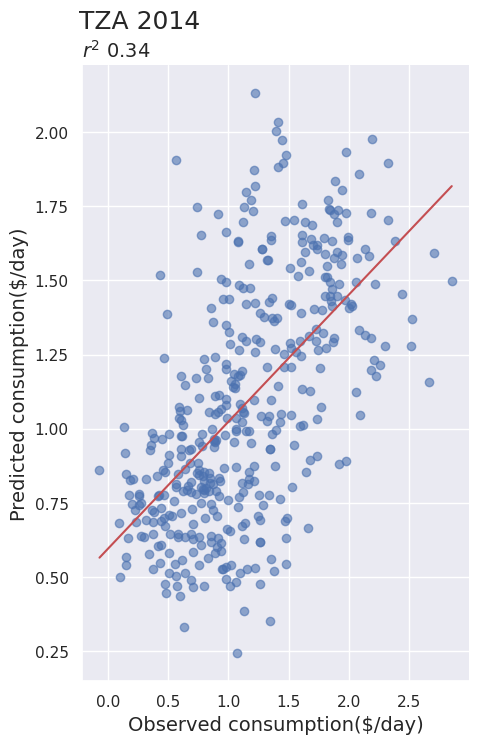

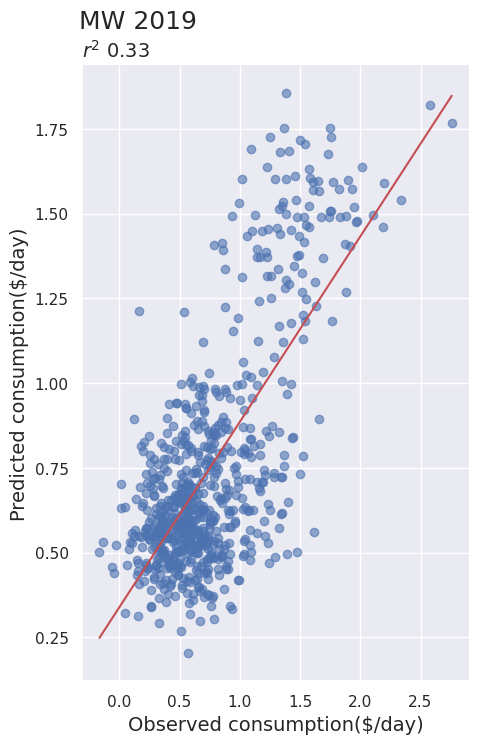

In [21]:
models_xgboost = []
for country, best_param in tqdm(zip(countries, best_params)):
    models_xgboost.append(cnn_osm(complete_df, XGBRegressor, best_param))

# Predictions with CatBoost

In [ ]:
    #Can take a lot of time to run, only if computer
best_params = None
#max_depth = np.arange(4,20, step = 3)
#n_estimators = np.arange(50,401, step = 25)
#best_params = optimize_params(complete_df, CatBoostRegressor(), params={'max_depth': max_depth, 'n_estimators': n_estimators}, seed=1)

In [ ]:
models_catboost = []
if best_params is None:
    for country in tqdm(countries):
        models_catboost.append(cnn_osm(complete_df, CatBoostRegressor, country, task_type="GPU"))
else :
    for country, best_param in tqdm(zip(countries, best_params)):
        models_catboost.append(cnn_osm(complete_df, CatBoostRegressor, country, best_params, task_type="GPU"))

# Plot features importance

In [ ]:
def features_importance_plot(models) :
    countries = ["NG", "ETH" ,"TZA", "MW"]
    for i, country in enumerate(countries) : 
        importance = models[i].feature_importances_
        cnn_features_names = [f'cnn{i}' for i in range(len(complete_df.features[0]))]
        features_names = np.concatenate((all_cols, cnn_features_names))
        mask = ~pd.Series(features_names).str.match(r'^cnn')
        
        fig, ax = plt.subplots(figsize=(10, 20))
        sorted_importance, sorted_features = zip(*sorted(zip(importance[mask], features_names[mask])))
        #sorted_importance, sorted_features = importance[mask], features_names[mask]
        ax.barh(sorted_features, sorted_importance)
        ax.set_yticklabels(sorted_features, fontsize=6)
        
        plt.xlabel('Importance', fontsize=14)
        plt.title(f'Features importance for {country}', fontsize=18)    
        plt.show()
        #plot_importance(models[i], importance_type='gain', title='Features importance', xlabel='Importance', ylabel='Features', grid=False, ax=ax)

### Features Importance with XGBoost

In [ ]:
features_importance_plot(models_xgboost)

### Features Importance with CatBoost

In [ ]:
features_importance_plot(models_catboost)

## Rural vs. Urban

In [ ]:
def rural_urban(complete):    
    types = ["rural", "urban"]
    types_r2 = {}
    rural = []
    ys = []
    y_preds = []
    # get features
    for type in types:    
        r2s = []
        countries = ["NG", "ETH" ,"TZA", "MW"]
        X = None
        y = None
        for i, country in enumerate(countries):
            tmp_df = complete.loc[complete.country == country]
            years = tmp_df.groupby(["year"]).groups.keys()
            year = max(years)
            year_df = tmp_df.loc[tmp_df.year == year]
            year_df = year_df.loc[year_df.rural == type]
            rural += year_df.rural.values.tolist()
            cnn_X = np.array([np.array(x) for x in year_df["features"].values])
            osm_X = year_df[all_cols].values
            tmp_X = np.hstack((cnn_X, osm_X))
            y_ = year_df["cons_pc"].values

            if X is None:
                X = tmp_X
            else:
                X = np.vstack((X, tmp_X))
            if y is None:
                y = y_
            else:
                y = np.append(y, y_)

        y = np.log(y)
        ys += y.tolist()
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)
        r, y_hest, _ = eu.run_ridge(X, y, alpha=1000)
        y_preds += y_hest.tolist()
        r2s.append(r)
        types_r2[type] = r2s

    # for the plot
    plt_df = pd.DataFrame.from_dict({"y": ys, "y_pred": y_preds, "rural": rural})

    x_col = "y"
    y_col = "y_pred"
    hue_col = "rural"

    penguins = plt_df
    g = sns.jointplot(data=penguins, x=x_col, y=y_col, hue=hue_col)
    
    for _, gr in penguins.groupby(hue_col):
        sns.regplot(x=x_col, y=y_col, data=gr, scatter=False, ax=g.ax_joint, truncate=False)
    print(types_r2)
    g.ax_joint.set_xlabel("Observed nominal consumption($/day)")
    g.ax_joint.set_ylabel("Predicted nominal consumption($/day)")
    plt.text(-0.8, 1, fr"$r^2 = {round(types_r2['rural'][0], 2)}$", c="#4c72b0")
    plt.text(-0.8, 0.8, fr"$r^2 = {round(types_r2['urban'][0], 2)}$", c="#dd8452")
    plt.legend([],[], frameon=False)
    g.ax_joint.get_legend().remove()
    g.ax_joint.text(-0.1, 1.1, string.ascii_uppercase[0], size=20, weight='bold', transform=g.ax_joint.transAxes)
    plt.savefig("../figs/rural_urban_pop.pdf", dpi=600, bbox_inches="tight")


In [ ]:
rural_urban(complete_df)

## Predict % of poorest people in dataset

In [ ]:
def pooled_features_perc(complete):   
    features = ["CNN", "OSM", "CNN+OSM"]
    feature_r2 = {}
    for feature in features:    
        r2s = []
        for i in tqdm(np.linspace(0.1,1,91)):
            perc_df = complete.loc[complete.cons_pc <= complete.cons_pc.quantile(i)]
            countries = ["NG", "ETH" ,"TZA", "MW"]
            X = None
            y = None
            for i, country in enumerate(countries):
                tmp_df = perc_df.loc[perc_df.country == country]
                years = tmp_df.groupby(["year"]).groups.keys()
                year = max(years)
                year_df = tmp_df.loc[tmp_df.year == year]
                if feature == "CNN":
                    tmp_X = np.array([np.array(x) for x in year_df["features"].values])
                elif feature == "OSM":
                    tmp_X = year_df[all_cols].values
                else:
                    cnn_X = np.array([np.array(x) for x in year_df["features"].values])
                    osm_X = year_df[all_cols].values
                    tmp_X = np.hstack((cnn_X, osm_X))
                    
                y_ = year_df["cons_pc"].values

                if X is None:
                    X = tmp_X
                else:
                    X = np.vstack((X, tmp_X))
                
                if y is None:
                    y = y_
                else:
                    y = np.append(y, y_)

            recent_df_complete = tmp_df.loc[tmp_df.year == year]
            split_map = cl.split_k_sets(10, lat=recent_df_complete["lat"], lon=recent_df_complete["lon"])
            y = np.log(y)
            scaler = StandardScaler().fit(X)
            X = scaler.transform(X)
            r2, y_real, y_predicted, trained_model = eu.run_model(X, y, Ridge, seed=1, kf= cl.folds_from_split(split_map), alpha=1000)
            r2s.append(r2)
        feature_r2[feature] = r2s
    
    colors = ["#2a9d8f", "#e9c46a", "#e76f51"]
    for i, feature in enumerate(feature_r2):
        plt.plot(np.linspace(0.1,1,91)*100, feature_r2[feature], c=colors[i], label=feature)
    
    plt.xlabel("Poorest percent of cluster used")
    plt.ylabel(r"$r^2$")
    plt.legend()
    ax = plt.gca()
    ax.text(-0.1, 1.1, string.ascii_uppercase[1], size=20, weight='bold', transform=ax.transAxes)
    plt.savefig("../figs/pooled_percentile.pdf", dpi=600, bbox_inches="tight")
    plt.show()

In [ ]:
pooled_features_perc(complete_df)

## Predicting performance from each feature alone and combined

In [9]:
def prediction_features_performance(complete):   
    features = ["CNN", "OSM", "CNN+OSM"]
    feature_r2 = {}
    for feature in features:    
        r2s = []        
        countries = ["NG", "ETH" ,"TZA", "MW"]
        X = None
        y = None
        for i, country in enumerate(countries):
            tmp_df = complete.loc[complete.country == country]
            years = tmp_df.groupby(["year"]).groups.keys()
            year = max(years)
            year_df = tmp_df.loc[tmp_df.year == year]
            if feature == "CNN":
                tmp_X = np.array([np.array(x) for x in year_df["features"].values])
                tmp_X = StandardScaler().fit_transform(tmp_X)
            elif feature == "OSM":
                tmp_X = year_df[all_cols].values
            else:
                cnn_X = np.array([np.array(x) for x in year_df["features"].values])
                osm_X = year_df[all_cols].values
                tmp_X = np.hstack((cnn_X, osm_X))
                
            y = year_df["cons_pc"].values

            X = tmp_X
           
            y = np.log(y)
            scaler = StandardScaler().fit(X)
            X = scaler.transform(X)
            recent_df_complete = tmp_df.loc[tmp_df.year == year]
            split_map = cl.split_k_sets(10, lat=recent_df_complete["lat"], lon=recent_df_complete["lon"])
            r2, y_real, y_predicted, trained_model = eu.run_model(X, y, Ridge, seed=1, kf= cl.folds_from_split(split_map), alpha=1000)
            r2s.append(r2)
            feature_r2[feature] = r2s
            
    feat_df = pd.DataFrame.from_dict(feature_r2)
    feat_df["country"] = countries
    return feat_df

In [11]:
prediction_features_performance(complete_df)

,CNN,OSM,CNN+OSM,country
0,0.198907,0.317814,0.439032,NG
1,0.155311,0.179293,0.203020,ETH
2,0.093251,0.341823,0.249102,TZA
3,0.043770,0.328937,0.323766,MW
